# Apple Stock prediction using LSTM
## Installing and importing necessary libraries


In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np



## Downloading data from **2016-01-01** till **2024-04-30**

[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2016-01-04  25.652500  26.342501  25.500000  26.337500  23.946918  270597600
2016-01-05  26.437500  26.462500  25.602501  25.677500  23.346823  223164000
2016-01-06  25.139999  25.592501  24.967501  25.174999  22.889936  273829600
2016-01-07  24.670000  25.032499  24.107500  24.112499  21.923876  324377600
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.039801  283192000
The number of data records:2093.


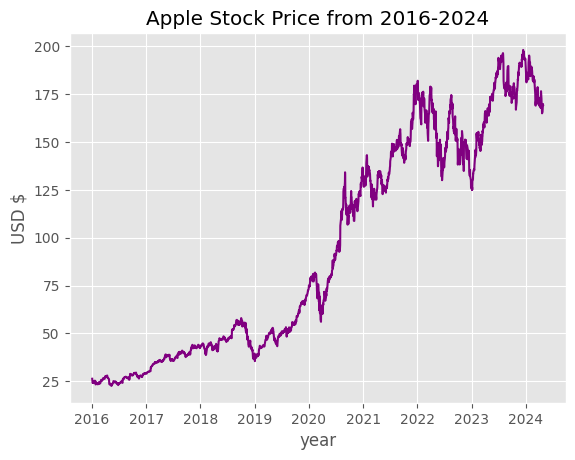

In [ ]:
data = yf.download("AAPL", start="2016-01-01", end="2024-04-29")
print(data.head())
plt.style.use('ggplot')
plt.plot(data.Close, color='purple')
plt.title('Apple Stock Price from 2016-2024')
plt.ylabel('USD $')
plt.xlabel('year')
print(f'The number of data records:{data.shape[0]}.')

For the sake of simplicity of the model, I will consider the date and closing price of stock as the input for the dataset. Fortunately, the current dataset, indexed by timestamp.

In [ ]:
data = data['Close']



## 2.1.Transforming data into a supervised learning dataset

To turn the model into a supervised learning, by considering the price of day $i$, $P_i$ as the response variable, then price of earlier $n$ days i.e. $P_{i-1},\ P_{i-2},\ \ldots,\ P_{i-n}$ are considered as the explanatory variables.

$$ P_i = f(P_{i-1},\ P_{i-2},\ \ldots,\ P_{i-n})$$

For the sake of simplicity of model, I set $n=5$.



In [ ]:
def Turn2Supervised(data,n:int):
    y = data.to_numpy()[n:]
    t = data.index[n:].to_numpy().astype('datetime64[D]')
    x = np.array([data.to_numpy()[i:i-n]   for i in range(n)]).T
    df = pd.DataFrame(np.hstack((x,y.reshape(x.shape[0],1))),
                                columns=['x'+str(i+1) for i in range(n)]+['y'],
                    index=t)
    return df,t,x,y
n:int = 5
df,t,x,y = Turn2Supervised(data,n)
df.head()

,x1,x2,x3,x4,x5,y
2016-01-11,26.337500,25.677500,25.174999,24.112499,24.240000,24.632500
2016-01-12,25.677500,25.174999,24.112499,24.240000,24.632500,24.990000
2016-01-13,25.174999,24.112499,24.240000,24.632500,24.990000,24.347500
2016-01-14,24.112499,24.240000,24.632500,24.990000,24.347500,24.879999
2016-01-15,24.240000,24.632500,24.990000,24.347500,24.879999,24.282499


## 2.2.1. Data Normalization
The data contains variables with different range. Data normalization is a process that reorganizes and improves the integrity of data to make it easier to work with, query, and analyze. It removes redundant and unstructured data, and creates a standardized format across an entire system. This can improve communication, decision-making, and information usability.
```x``` and ```y``` will be between $(-1,1)$ after normalization.

In [ ]:
#%%
normalize = MinMaxScaler(feature_range=(-1,1))
xbar = normalize.fit_transform(x)
ybar = normalize.fit_transform(y.reshape(y.size,1))

dfbar = pd.DataFrame(np.hstack((xbar,ybar)),columns=['xb'+str(i) for i in range(1,n+1)]+['y'],index= t )
xbar = xbar.reshape((x.shape[0], x.shape[1], 1))
dfbar.head()


,xb1,xb2,xb3,xb4,xb5,y
2016-01-11,-0.957243,-0.964763,-0.970489,-0.982595,-0.981142,-0.976670
2016-01-12,-0.964763,-0.970489,-0.982595,-0.981142,-0.976670,-0.972597
2016-01-13,-0.970489,-0.982595,-0.981142,-0.976670,-0.972596,-0.979917
2016-01-14,-0.982595,-0.981142,-0.976670,-0.972596,-0.979917,-0.973850
2016-01-15,-0.981142,-0.976670,-0.972596,-0.979917,-0.973850,-0.980658


The key aspect of the definition revolves around the input's structure, specifying what the model anticipates as input for every sample, including the **time step count** and **feature number**.

In our case, since we are dealing with a univariate series, then it means that we are having a single feature, representing one variable.

The input's time step count, i.e. $n$ is the value we selected during the dataset preparation.

The structure of each sample's input is detailed within the input_shape argument in the initial hidden layer's definition.

Since we typically handle multiple samples, the model expects the training data's input part to adhere to the specified dimensions or shape : ```[samples, timesteps, features]```

In [ ]:
t.shape, xbar.shape, y.shape

((2088,), (2088, 5, 1), (2088,))

## 2.2.2. Spliting data to train and test

The time series split guarantees that the test datasets occur after the train datasets in time, reflecting a more realistic scenario where we cannot train on data from the future. To do the splitting, I use $80-20\%$ split for train and test, while test dates are after train dates.

Text(0.5, 1.0, 'Split of data between train and test')

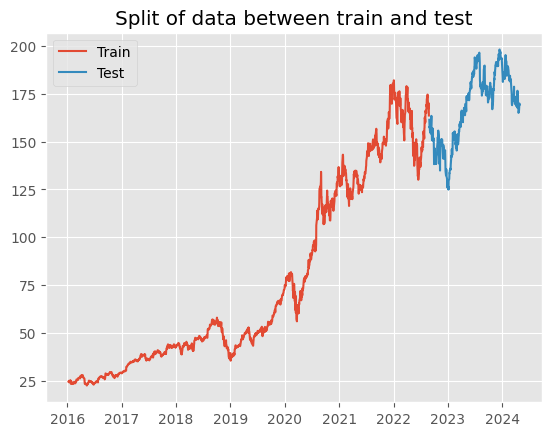

In [ ]:
v = int(0.8*x.shape[0])
x_train, x_test = xbar[:v,:],xbar[v:,:]
y_train, y_test = ybar[:v],ybar[v:]
plt.plot(t[:v],y[:v],label='Train')
plt.plot(t[v:],y[v:],label='Test')

plt.legend()
plt.title("Split of data between train and test")

# 2.3 Design LSTM architecture
The  following hyperparameters are considered:
- Number of LSTM layers: $\{1,\underline{3},5\}$
- Number of LSTM units in each layer: $\{32,\underline{64},128\}$
- Dropout rate: $\{0.2,\underline{0.3}\}$
- Learning rate: $\{\underline{0.001},0.005\}$
- Batch size: $\{32,\underline{64},128\}$
- Number of epochs $\{100,\underline{200}\}$

The defult values are the underlined values.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from itertools import product as prd
from tqdm import tqdm

def create_lstm_model(num_layers, num_units, dropout_rate, learning_rate, batch_size):
    model = Sequential()

    for i in range(num_layers):
        if i == 0:
            # First layer needs input_shape
            model.add(LSTM(units=num_units, return_sequences=True, input_shape=(xbar.shape[1], xbar.shape[2])))
            model.add(Dropout(dropout_rate))
        elif i == num_layers - 1:
            # Last layer doesn't return sequences
            model.add(LSTM(units=num_units))
            model.add(Dropout(dropout_rate))
        else:
            model.add(LSTM(units=num_units, return_sequences=True))
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Output layer

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')  # Mean Squared Error loss for regression

    return model
MODELS = {}
hyper_parameters= [[1,3,5],[32,64,128],[0.2,.3],[.001,.005], [32,64,128],[100,200]]
defult_parameters = [3,64,0.3,0.001,64,200]
cases = []
for j in range(len(defult_parameters)):
    for i in hyper_parameters[j]:
        cases.append(defult_parameters[:j]+[i]+defult_parameters[j+1:])


for num_layer,num_unit,drp_rate,lr,batch_size,num_epoch in tqdm(cases):
    MODELS[num_layer,num_unit,drp_rate,lr,batch_size,num_epoch] = create_lstm_model(num_layer,
                                                                                          num_unit, drp_rate, lr, batch_size)


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


## 2.4. Train Models with different hyperparameters

In [ ]:
for num_layer,num_unit,drp_rate,lr,batch_size,num_epoch in tqdm(cases):
    print(f'********** parameters: {num_layer,num_unit,drp_rate,lr,batch_size,num_epoch}*******')
    MODELS[num_layer,num_unit,drp_rate,lr,batch_size,num_epoch].fit(x_train, y_train, batch_size=batch_size, epochs=num_epoch)


In [ ]:
Hyper_parameter_name = ['Number of Layers', 'Number of Units', 'Dropping rate',
                        'Learning Rate', 'Batch Size', 'Number of Epoch']
Performance_measure = ['MSE','MAE','RMSE']

## 2.5 Error on Training and Testing set


53/53 [==============================] - 2s 5ms/step


Text(0.5, 1.0, 'Prediction of normalized train data')

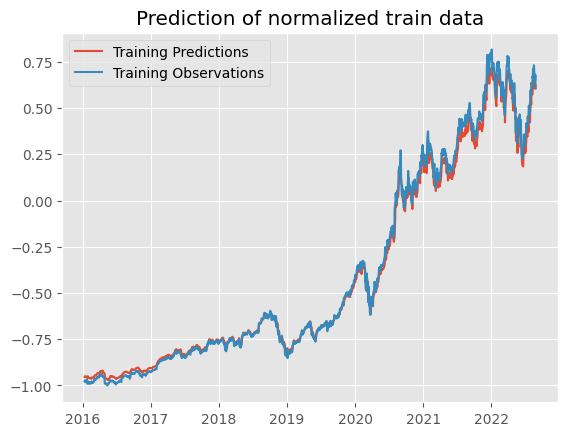

In [ ]:
y_hat = MODELS[3,64,0.3,0.001,64,200].predict(x_train).flatten()

plt.plot(t[:v], y_hat)
plt.plot(t[:v], y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.title("Prediction of normalized train data")

14/14 [==============================] - 0s 7ms/step


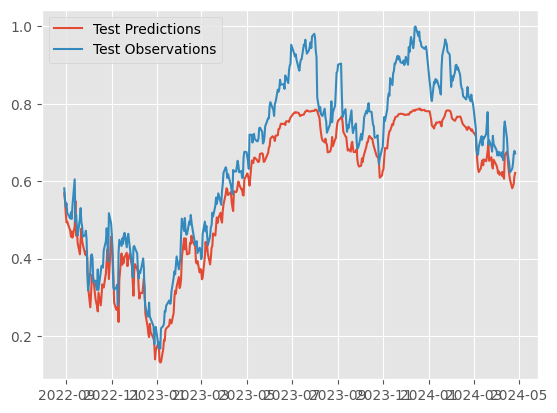

In [ ]:
y_hat_test = MODELS[3,64,0.3,0.001,64,200].predict(x_test).flatten()

plt.plot(t[v:], y_hat_test)
plt.plot(t[v:], y_test)
plt.legend(['Test Predictions', 'Test Observations'])

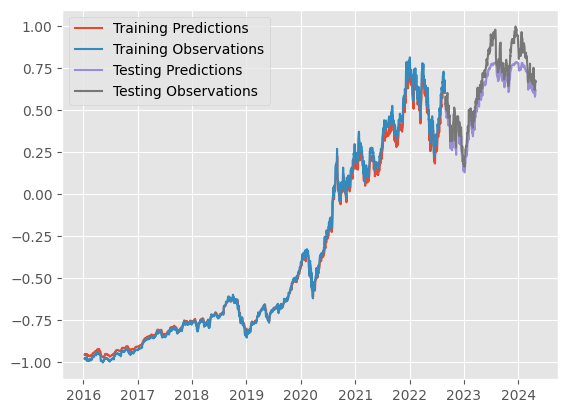

In [ ]:
plt.plot(t[:v], y_hat)
plt.plot(t[:v], y_train)
plt.plot(t[v:], y_hat_test)
plt.plot(t[v:], y_test)

plt.legend(['Training Predictions',
            'Training Observations',
            'Testing Predictions',
            'Testing Observations'])

## 2.6 & 2.7: Experiment with different hyperparameters:



In [ ]:
from tensorflow.keras.metrics import MSE,MAE
perf_train,perf_test ={},{}
for j in range(len(defult_parameters)):
    perf_train[Hyper_parameter_name[j]],perf_test[Hyper_parameter_name[j]] = {},{}
    for i in hyper_parameters[j]:
        y_h_train = MODELS[tuple(defult_parameters[:j]+[i]+defult_parameters[j+1:])].predict(x_train).flatten()
        y_h_test = MODELS[tuple(defult_parameters[:j]+[i]+defult_parameters[j+1:])].predict(x_test).flatten()
        perf_train[Hyper_parameter_name[j]][i] = [np.mean(MSE(y_pred=y_h_train,y_true=y_train)),
                                                  np.mean(MAE(y_pred=y_h_train,y_true=y_train)),
                                                  np.mean(MSE(y_pred=y_h_train,y_true=y_train))**0.5]
        perf_test[Hyper_parameter_name[j]][i] = [np.mean(MSE(y_pred=y_h_test,y_true=y_test)),
                                                  np.mean(MAE(y_pred=y_h_test,y_true=y_test)),
                                                  np.mean(MSE(y_pred=y_h_test,y_true=y_test))**0.5]

14/14 [==============================] - 0s 5ms/step


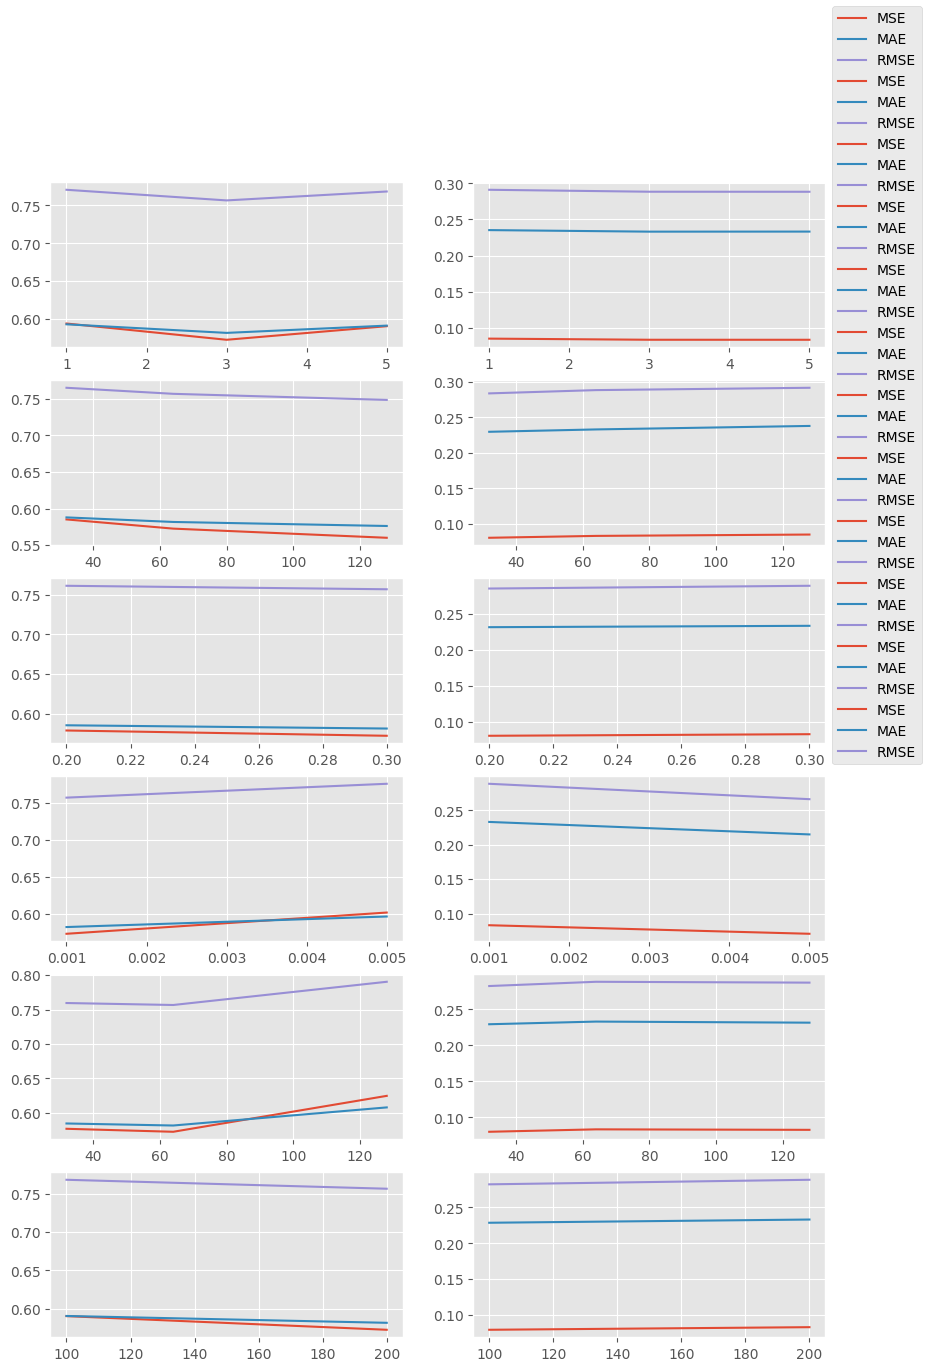

In [ ]:
measure = ['MSE','MAE','RMSE']
fig, axs = plt.subplots(6, 2, figsize=(10, 15))
for i,name in enumerate(Hyper_parameter_name):
    for k in range(3):
        axs[i,0].plot([j for j in perf_train[name]],[perf_train[name][j][k] for j in perf_train[name]],label=measure[k])
        axs[i,1].plot([j for j in perf_test[name]],[perf_test[name][j][k] for j in perf_test[name]],label=measure[k])
fig.legend()
